## Parse FFSimmer Rupture File & plot fault planes
A point is defined as a set of latitude, longitude, and depth, which
is located in the corner between the tail of the vector pointing in
the strike direction and the dip direction (nearest to the surface).
The shape is defined by length, width, dx, and dy. The length is the
measurement of the quadrilateral in the direction of strike, and
width is the measurement of quadrilateral in the direction of dip.
Dx is the measurement on the plane in the strike direction between
the known point and the corner between the tail of the vector pointing
in the strike direction and the dip direction (nearest to the surface).
Dy is the measurement on the plane in the dip direction between
the known point and the corner between the tail of the vector pointing
in the strike direction and the dip direction (nearest to the surface).
The orientation is defined by azimuth and angle from
horizontal, strike and dip respectively. For example in plane view:
```
                    strike direction
                p1*------------------->>p2
                *        | dy           |
         dip    |--------o              |
      direction |   dx    known point   | Width
                |                       |
                V                       |
                p4----------------------p3
                        Length
```

In [3]:
import pandas as pd
import pygmt
import os
import math
import numpy as np

In the example below, each row represents a single rupture plane defined by 5 points, each with lat/lon/depth, (p1, p2, p3, p4, p1)

In [ ]:
# Path to shakemap event directory (at the level of `current`)
file_path = '/Users/hyin/shakemap_profiles/default/data/us7000pn9s/v01_ffsim-constrained-w-aspect/products_rename/'
file = file_path + 'rupt_quads.txt'
hypocenter = [95.925, 22.001]   # lon, lat??
rgn = [92, 100, 16, 25]


def parse_rupture_file(file):
    ruptures = []  # List to store all ruptures
    current_rupture = []  # Temporary list to store points for the current rupture

    with open(file, "r") as file:
        for line in file:
            line = line.strip()
            if line.startswith("#Origin"):
                # Start of a new rupture, reset the current rupture
                current_rupture = []
            elif line == ">":
                # End of the current rupture, process and store it
                if len(current_rupture) == 5:  # Ensure there are 5 points
                    rupture = {
                        "p1": current_rupture[0],
                        "p2": current_rupture[1],
                        "p3": current_rupture[2],
                        "p4": current_rupture[3],
                    }
                    ruptures.append(rupture)
                current_rupture = []  # Reset for the next rupture
            elif line:
                # Parse a point (lat, lon, depth)
                point = tuple(map(float, line.split()))
                current_rupture.append(point)
    data = []
    for idx, rupture in enumerate(ruptures):
        data.append({
            "rupture_id": idx + 1,
            "p1_lat": rupture["p1"][0], "p1_lon": rupture["p1"][1], "p1_depth": rupture["p1"][2],
            "p2_lat": rupture["p2"][0], "p2_lon": rupture["p2"][1], "p2_depth": rupture["p2"][2],
            "p3_lat": rupture["p3"][0], "p3_lon": rupture["p3"][1], "p3_depth": rupture["p3"][2],
            "p4_lat": rupture["p4"][0], "p4_lon": rupture["p4"][1], "p4_depth": rupture["p4"][2],
        })
    
    return pd.DataFrame(data)

ruptures = parse_rupture_file(file)

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    Args:
        lat1, lon1: Latitude and longitude of point 1 in decimal degrees.
        lat2, lon2: Latitude and longitude of point 2 in decimal degrees.
    Returns:
        Distance in kilometers.
    """
    R = 6371.0  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

ruptures["fault_length_km"] = ruptures.apply(lambda row: haversine(row["p1_lat"], row["p1_lon"], row["p2_lat"], row["p2_lon"]), axis=1)
ruptures["fault_width_km"] = np.sqrt((ruptures.apply(lambda row: haversine(row["p1_lat"], row["p1_lon"], row["p4_lat"], row["p4_lon"]), axis=1)**2)+ (ruptures["p4_depth"]**2))
ruptures["aspect_ratio"] = ruptures["fault_length_km"] / ruptures["fault_width_km"]

# Calculate average aspect ratio
avg_aspect = ruptures["aspect_ratio"].mean()
avg_fault_length = ruptures["fault_length_km"].mean()
# Calculate average updip depth
avg_updip_depth = ruptures[["p1_depth"]].mean(axis=1).mean()
avg_downdip_depth = ruptures[["p3_depth"]].mean(axis=1).mean()
print(f"Average aspect ratio: {avg_aspect:.2f}")
print(f"Average Fault length: {avg_fault_length:.2f} km")
print(f"Average updip depth: {avg_updip_depth:.2f} km")
print(f"Average downdip depth: {avg_downdip_depth:.2f} km")




FileNotFoundError: [Errno 2] No such file or directory: '/Users/hyin/shakemap_profiles/default/data/us7000pn9s/v01_ffsim-constrained-w-aspect/rupt_quads.txt'

## Create PyGMT fig of fault traces

ERROR 1: Features without geometry not supported by GMT writer.
ERROR 1: Features without geometry not supported by GMT writer.


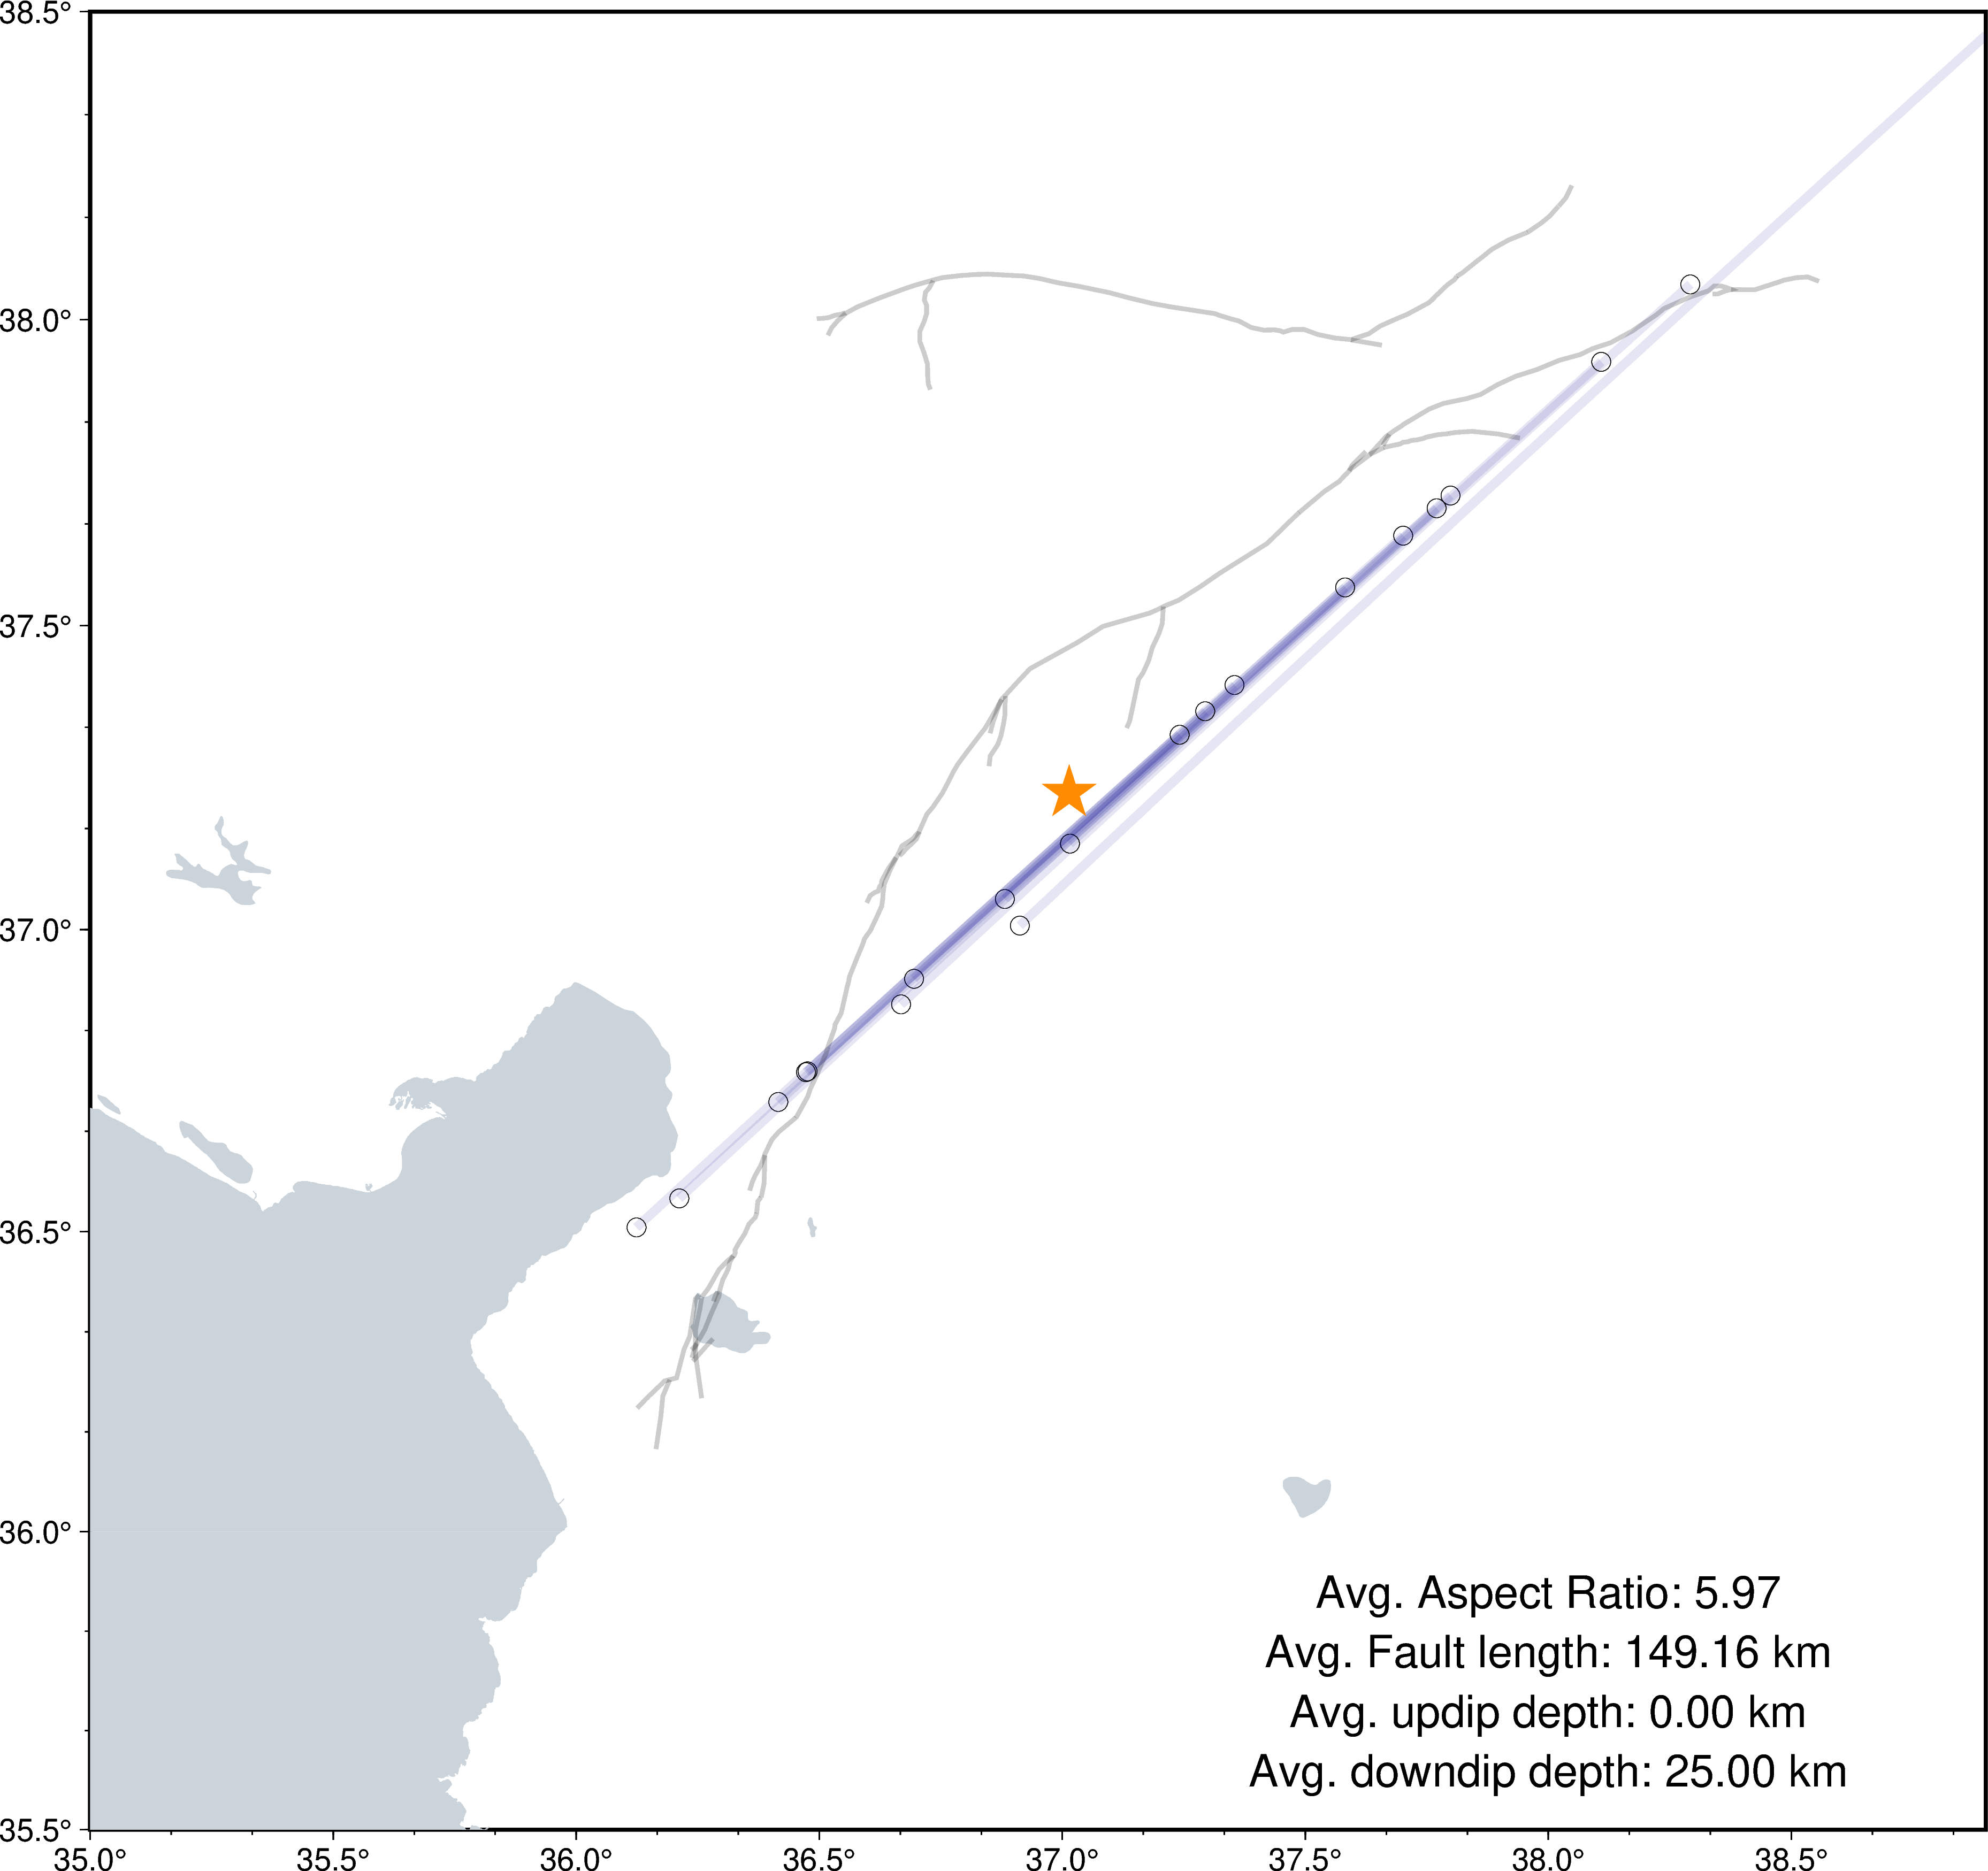

In [ ]:
directory = file_path

# Initialize figure
fig = pygmt.Figure()
# Set PyGMT universal configurations
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT="14p")
projection = 'M0/0/30c'

fig.basemap(region=rgn, projection=projection, frame=True)
fig.coast(shorelines=False, region=rgn, projection=projection, water='204/212/219')
## Plot Fault ruptures (iterate over each fault)
for index, row in ruptures.iterrows():
  p1 = [row['p1_lon'],row['p1_lat']]
  p2 = [row['p2_lon'],row['p2_lat']]
  # p3 = row['lons'][2]
  # p4 = row['lons'][3]
  fig.plot(x=[p1[0], p2[0]], y=[p1[1], p2[1]], pen='4p,darkblue',  transparency=90, label=f"Fault Realizations +S.5c", region=rgn, projection=projection)
  fig.plot(x=[p1[0], p2[0]], y=[p1[1], p2[1]], style="c0.3c", pen="black")



# Plot hypocenter
fig.plot(x=hypocenter[0], y = hypocenter[1], style="a0.9c", fill="darkorange", label="M7.8 Hypocenter")

# USGS Fault rupture
file = '/Users/hyin/usgs_mendenhall/2023_turkey_pathways/map-layers/map_layers/Turkey_Emergency_EQ_Data/simple_fault_2023-03-15/simple_fault_2023-3-15.shp'
fig.plot(data=file, pen='2p,black', transparency=80, label=f"Surface rupture (USGS)+S.5c", region=rgn, projection=projection)

## Plot some stats about the ruptures
fig.text(position="BR", offset="-2c/5c", text="Avg. Aspect Ratio: " + str(round(avg_aspect,2)) ,font="20p,Helvetica,black")
fig.text(position="BR", offset="-2c/4c", text=f"Avg. Fault length: {avg_fault_length:.2f} km" ,font="20p,Helvetica,black")
fig.text(position="BR", offset="-2c/3c", text=f"Avg. updip depth: {avg_updip_depth:.2f} km" ,font="20p,Helvetica,black")
fig.text(position="BR", offset="-2c/2c", text=f"Avg. downdip depth: {avg_downdip_depth:.2f} km" ,font="20p,Helvetica,black")

# print(f"Average aspect ratio: {avg_aspect:.2f}")
# print(f"Average updip depth: {avg_updip_depth:.2f} km")
# print(f"Average downdip depth: {avg_downdip_depth:.2f} km")
# f"Average Fault length: {avg_fault_length:.2f} km"

fig.show()
fig.savefig(directory+'/ruptures_map-view.png')
